<a href="https://colab.research.google.com/github/apal9569/Driver-Distraction/blob/master/driver_distraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
cd drive/My Drive

/content/drive/My Drive


In [0]:
cd final_project/state-farm-distracted-driver-detection/

/content/drive/My Drive/final_project/state-farm-distracted-driver-detection


In [0]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
import os
import glob
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import h5py
from skimage import color

# **STATE FARM DATASET**

In [0]:
driver_list=pd.read_csv('driver_imgs_list.csv',na_values='na')
driver_list['subject'].value_counts()


In [0]:
no_of_class=10
images=[]
faces=[]

for i in tqdm(range(no_of_class)):
  
  files=os.listdir("imgs/train/c"+str(i))
  for j in range(len(files)):
    
    img_name = "imgs/train/c"+str(i)+"/"+files[j]
    
    img=cv2.imread(img_name)
    
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    full_img = img[50:,70:-50]
    full_img = cv2.resize(full_img,(224,224))
    
    driver = driver_list.loc[driver_list['img'] == files[j]]['subject']
    images.append([full_img,i,driver])   

100%|██████████| 10/10 [2:40:28<00:00, 962.83s/it]


In [0]:
import random
random.shuffle(images)
#random.shuffle(faces)
driv_selected = ['p026', 'p024','p021','p022']

**PROPER IMAGE**

In [0]:
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in images:
  #print(drivers)  
  for d in drivers:
    if d not in driv_selected:
      X_train.append(features)
      y_train.append(labels)
    
    else:
       
      X_test.append(features)
      y_test.append(labels)


17532 4892
17532 4892


In [0]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt


In [0]:

train_label=to_categorical(y_train,10)
test_label=to_categorical(y_test,10)

train_label.shape

(17532, 10)

In [0]:
train_img = np.array(X_train).reshape(-1,224,224,3)
test_img = np.array(X_test).reshape(-1,224,224,3)
train_img.shape,test_img.shape

((17532, 224, 224, 3), (4892, 224, 224, 3))

In [0]:
del X_train,X_test

# **Image Data Generator**

In [0]:

datagen = ImageDataGenerator(
            rotation_range=30,  
            width_shift_range=0.5,
            height_shift_range=0.5,
            zoom_range=0.5,  
            horizontal_flip=False,  
            vertical_flip=False,  
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)

full_generator=datagen.flow(train_img,train_label,batch_size=32)

# **VGG19**

---



In [0]:
#VGG16
from tensorflow.keras.layers import Input
vgg19_input = Input(shape = (224, 224, 3), name = 'Image_input')

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

model_vgg19 = VGG19(weights='imagenet', include_top=False, input_tensor = vgg19_input)
model_vgg19.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_vgg19 = model_vgg19(vgg19_input)

x = Flatten(name='flatten')(output_vgg19)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg19_pretrained = Model(inputs = vgg19_input, outputs = x)
vgg19_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0005)
vgg19_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
vgg19_history = vgg19_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 15, verbose = 1, validation_data = (test_img, test_label))

# **RESNET50V2**

In [0]:
#VGG16
from tensorflow.keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input, ResNet101V2

model_resnet50 = ResNet50V2(weights='imagenet', include_top=False, input_tensor = resnet50_input)
model_resnet50.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_resnet50 = model_resnet50(resnet50_input)

x = Flatten(name='flatten')(output_resnet50)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

resnet50_pretrained1 = Model(inputs = resnet50_input, outputs = x)
resnet50_pretrained.summary()
resnet50_pretrained1.load_weights('resnet_weights_aug_alltrained_sgd2_setval.hdf5')
# Compile CNN model
sgd = SGD(lr = 0.0005)
resnet50_pretrained1.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5',monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#earlystopper = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

resnet50_model = resnet50_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 25, verbose = 1, callbacks= [checkpointer], validation_data = (test_img, test_label))

# **INCEPTION**

In [0]:
from tensorflow.keras.layers import Input
inceptionv3_input = Input(shape = (299, 299, 3), name = 'Image_input')

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_tensor = inceptionv3_input)
model_inceptionv3.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_inceptionv3 = model_inceptionv3(inceptionv3_input)

x = Flatten(name='flatten')(output_inceptionv3)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

inceptionv3_pretrained = Model(inputs = inceptionv3_input, outputs = x)
inceptionv3_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0005)
inceptionv3_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
inceptionv3_history1 = inceptionv3_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 5, verbose = 1, validation_data = (test_img, test_label))

# **DenseNet**

In [0]:
from tensorflow.keras.layers import Input
DenseNet_input = Input(shape = (224, 224, 3), name = 'Image_input')

from tensorflow.keras.applications import DenseNet201

model_DenseNet = DenseNet201(weights='imagenet', include_top=False, input_tensor = DenseNet_input)
model_DenseNet.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_DenseNet = model_DenseNet(DenseNet_input)

x = Flatten(name='flatten')(output_DenseNet)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

DenseNet_pretrained = Model(inputs =DenseNet_input, outputs = x)
DenseNet_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0005)
DenseNet_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
DenseNet_history = DenseNet_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 5, verbose = 1, validation_data = (test_img, test_label))

# **MobileNet**

In [0]:
from tensorflow.keras.layers import Input
mobileNet_input = Input(shape = (224, 224, 3), name = 'Image_input')

from tensorflow.keras.applications import MobileNetV2

model_mobileNet = MobileNetV2(weights='imagenet', include_top=False, input_tensor = mobileNet_input)
model_mobileNet.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_mobileNet = model_mobileNet(mobileNet_input)

x = Flatten(name='flatten')(output_mobileNet)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

mobileNet_pretrained = Model(inputs =mobileNet_input, outputs = x)
mobileNet_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0005)
mobileNet_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
mobileNet_history = mobileNet_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 15, verbose = 1, validation_data = (test_img, test_label))

# **Xception**

In [0]:
from tensorflow.keras.layers import Input
xception_input = Input(shape = (299, 299, 3), name = 'Image_input')

from tensorflow.keras.applications import Xception

model_xception = Xception(weights='imagenet', include_top=False, input_tensor = xception_input)
model_xception.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_xception = model_xception(xception_input)

x = Flatten(name='flatten')(output_xception)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

xception_pretrained = Model(inputs = xception_input, outputs = x)
xception_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0005)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

In [0]:
xception_history = xception_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 15, verbose = 1, validation_data = (test_img, test_label))

# **Inception ResNet**

In [0]:
from tensorflow.keras.layers import Input
inceptionresnetv2_input = Input(shape = (299, 299, 3), name = 'Image_input')

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

model_inceptionresnetv2 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor = inceptionresnetv2_input)
model_inceptionresnetv2.summary()

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

output_inceptionresnetv2 = model_inceptionresnetv2(inceptionresnetv2_input)

x = Flatten(name='flatten')(output_inceptionresnetv2)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

inceptionresnetv2_pretrained = Model(inputs = inceptionresnetv2_input, outputs = x)
inceptionresnetv2_pretrained.summary()

# Compile CNN model
sgd = SGD(lr = 0.0009)
inceptionresnetv2_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

In [0]:
inceptionresnet2_history = inceptionresnetv2_pretrained.fit_generator(full_generator,steps_per_epoch = len(train_img) / 32, 
                                                            epochs = 20, verbose = 1, validation_data = (test_img, test_label))

**Accuracy Plot**

[0.3289051532745361, 0.5340333461761475, 0.6715195655822754, 0.742307710647583, 0.8115227103233338, 0.8362198948860169, 0.8491190552711487, 0.8517932772636414, 0.8434560179710389, 0.8635913014411927, 0.8731870532035828, 0.8736589431762696, 0.8775916576385498, 0.850062894821167]


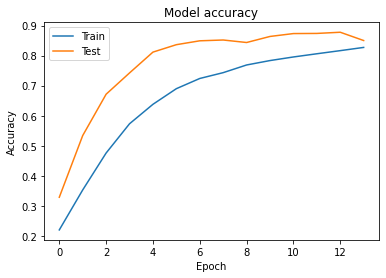

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(mobileNet_history.history['accuracy'])
plt.plot(mobileNet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy_mobilenet')


**Confusion Matrix Generation**

In [0]:
y_pred=mobileNet_pretrained.predict(test_img)

y_true=np.argmax(test_label,axis=1)
prediction=np.argmax(y_pred,axis=1)

con_mat = tf.math.confusion_matrix(y_true, prediction, num_classes=10)
summ=np.sum(con_mat,axis=1)
con_mat_norm = np.around(con_mat / summ[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1,2,3,4,5,6,7,8,9], 
                     columns = [0,1,2,3,4,5,6,7,8,9])

print(con_mat_df)

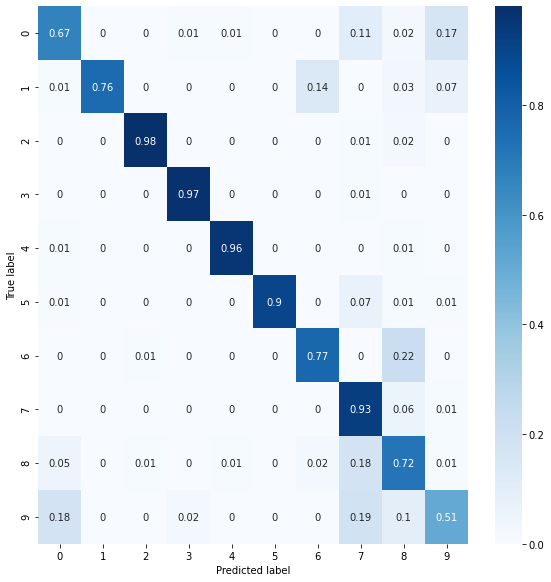

In [0]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("mobilenet_Cmatrix")

**Prediction on Test Images**

In [0]:
classtype={0:"safe driving",1:"texting-right",2:"talking phone right",3:"texting left",4:"talking phone left",
           5:"operating radio",6:"drinking",7:"reaching behind",8:"hair and makeup",9:"talking to passenger"}

In [0]:
count=0
for label,img in zip(y_true, test_img):
  img=cv2.resize(img,(480,480))
  if label!=0:
    text="stop "+classtype[label]+" Please!"
    text2="Alert System: ON"
    
  else:
    text="Cool! You are paying attention."
    text2="Alert System: OFF"
  font                   = cv2.FONT_HERSHEY_SIMPLEX
  bottomLeftCornerOfText = (10,50)
  fontScale              = 0.5
  fontColor              = (0,0,255)
  lineType               = 2
  cv2.putText(img,str(text), 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
  
  font                   = cv2.FONT_ITALIC
  bottomLeftCornerOfText = (10,400)
  fontScale              = 0.5
  fontColor              = (0,0,255)
  lineType               = 2
  cv2.putText(img,str(text2), 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
  
  cv2_imshow(img)
  
  count=count+1

**Generating Videos of the predicted Images**

In [0]:
images=glob.glob('*.jpg')

In [0]:
out = cv2.VideoWriter('prediction3.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 0.5, (480,480))
 
for f in images:
  i=cv2.imread(str(f))
  out.write(i)
out.release()